In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from keras. utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam 




In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
df = pd.read_csv('DataSets/TATAMOTORS_02_JUN_1991_14_JUN_2024.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-02,20.959597,21.857864,20.959597,21.857864,15.690223,0.0
1,1991-01-03,20.959597,21.857864,20.959597,21.857864,15.690223,0.0
2,1991-01-04,21.857864,21.857864,21.857864,21.857864,15.690223,0.0
3,1991-01-07,20.360750,21.259020,20.061329,21.109308,15.152885,0.0
4,1991-01-08,21.109308,21.109308,21.109308,21.109308,15.152885,0.0


In [8]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8454,2024-06-10,977.000000,984.900024,969.099976,975.150024,972.150024,9258931.0
8455,2024-06-11,973.799988,992.549988,966.650024,987.099976,987.099976,14828702.0
8456,2024-06-12,994.500000,1010.250000,987.000000,988.700012,988.700012,17527993.0
8457,2024-06-13,1002.000000,1002.000000,980.750000,985.849976,985.849976,12157226.0
8458,2024-06-14,990.000000,997.250000,981.400024,993.400024,993.400024,11591421.0


In [9]:
df = df.dropna()
df = df[df['Volume']!=0]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7138 entries, 1178 to 8458
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7138 non-null   object 
 1   Open       7138 non-null   float64
 2   High       7138 non-null   float64
 3   Low        7138 non-null   float64
 4   Close      7138 non-null   float64
 5   Adj Close  7138 non-null   float64
 6   Volume     7138 non-null   float64
dtypes: float64(6), object(1)
memory usage: 446.1+ KB


In [11]:

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7138.000000,7138.000000,7138.000000,7138.000000,7138.000000,7.138000e+03
mean,211.315819,214.385869,207.818125,210.980768,203.117295,1.519189e+07
std,189.868939,191.860736,187.401432,189.547886,192.250175,2.028181e+07
min,11.114574,11.631977,11.028340,11.267879,9.043228,2.896100e+04
25%,68.815349,70.043875,67.253084,68.680405,52.078042,5.393492e+06
50%,146.844513,149.603004,142.779175,146.544021,132.790619,9.377462e+06
75%,333.562500,337.819389,326.836205,333.070015,330.372642,1.674081e+07
max,1038.000000,1065.599976,1030.400024,1046.650024,1043.430054,3.905778e+08


In [12]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ', df. shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (7138, 7)
Null Value Present:  False


<Axes: >

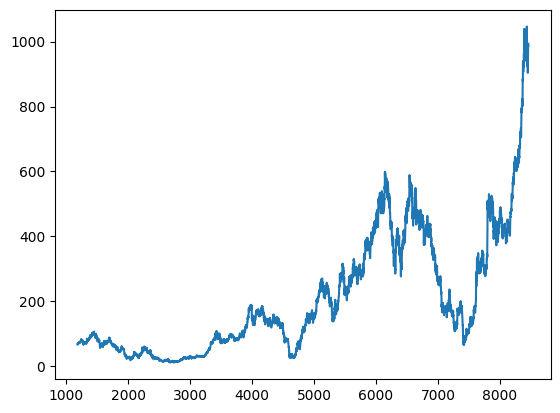

In [13]:
#Plot the Close Value
df['Close'].plot()

In [14]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])

#Selecting the Feature
features = ['Open', 'Low', 'High', 'Volume']

In [15]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features]) # Scalling 
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index) # Convert to saprate Dataframe 
feature_transform.head()

,Open,Low,High,Volume
1178,0.054491,0.054507,0.052827,0.000951
1180,0.054491,0.054977,0.053736,0.000506
1181,0.055657,0.055917,0.054418,0.000741
1182,0.056357,0.056622,0.056691,0.002931
1183,0.058457,0.057797,0.057145,0.001670


In [12]:
#Splitting to Training set and Test set

timesplit=TimeSeriesSplit(n_splits=5,test_size=int(len(df)*0.2)) # number of split 
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [13]:
# Printing the shape of Training and Test set 
print("Traning shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("Traning Data percentage:", (X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)
print("Test Data percentage:", (X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)


Traning shape: (5711, 4)
Test shape: (1427, 4)
Traning Data percentage: 80.0084057158868
Test Data percentage: 19.991594284113198


In [14]:
#Process the data for LSTM & reshape the data for LSTM to (batch_size, timesteps, input_dim) 

trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Traning shape:", X_train.shape)
print("Test shape:", X_test.shape)

Traning shape: (5711, 1, 4)
Test shape: (1427, 1, 4)


In [41]:

from tensorflow.keras.regularizers import l2


#Building the LSTM Model

lstm = Sequential()
lstm.add(LSTM(units=256, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True, 
            kernel_regularizer=l2(0.001), 
            use_bias=True))

lstm.add(Dropout(0.2))
lstm.add(LSTM(units=128, activation='relu', return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=16, activation='relu', return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(Dense(1))

# optimizer = Adam(learning_rate=0.001) 
optimizer = 'adam'

lstm.compile(loss='mean_squared_error', 
             optimizer= optimizer, #'adam',
            )

# plot_model(lstm, show_shapes=True, show_layer_names=True)

lstm.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 1, 256)            267264    
                                                                 
 dropout_42 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_87 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_43 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_88 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_44 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_89 (LSTM)              (None, 1, 16)            

In [42]:
# Model Check Point & Early Stopping

Model_checkpoint_path = "TataMotors_Stock_Price_Prediction.hdf5"

callback = [EarlyStopping(monitor='val_loss', patience = 10, verbose=1),
            ModelCheckpoint(Model_checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')]

In [43]:
with tf.device('GPU'):
    history=lstm.fit(X_train, 
                     y_train, 
                     validation_data=(X_test,y_test),
                     epochs=500, 
                     batch_size=128,
                     verbose=1, 
                     shuffle=False, 
                     callbacks=callback)

Epoch 1/500
45/45 [==============================] - ETA: 0s - loss: 52938.0508
Epoch 1: val_loss improved from inf to 190122.35938, saving model to TataMotors_Stock_Price_Prediction.hdf5
45/45 [==============================] - 9s 105ms/step - loss: 52938.0508 - val_loss: 190122.3594
Epoch 2/500
45/45 [==============================] - ETA: 0s - loss: 48018.3125
Epoch 2: val_loss improved from 190122.35938 to 141279.23438, saving model to TataMotors_Stock_Price_Prediction.hdf5
45/45 [==============================] - 2s 48ms/step - loss: 48018.3125 - val_loss: 141279.2344
Epoch 3/500
45/45 [==============================] - ETA: 0s - loss: 9632.7246
Epoch 3: val_loss improved from 141279.23438 to 14135.11328, saving model to TataMotors_Stock_Price_Prediction.hdf5
45/45 [==============================] - 2s 48ms/step - loss: 9632.7246 - val_loss: 14135.1133
Epoch 4/500
45/45 [==============================] - ETA: 0s - loss: 12894.5156
Epoch 4: val_loss improved from 14135.11328 to 815

In [44]:
#LSTM Prediction
y_pred= lstm.predict(X_test)
y_pred.shape

45/45 [==============================] - 1s 16ms/step


(1427, 1, 1)

In [45]:

y_pred = y_pred.reshape(-1,1)
y_pred.shape

(1427, 1)

In [46]:
y_test.shape

(1427,)

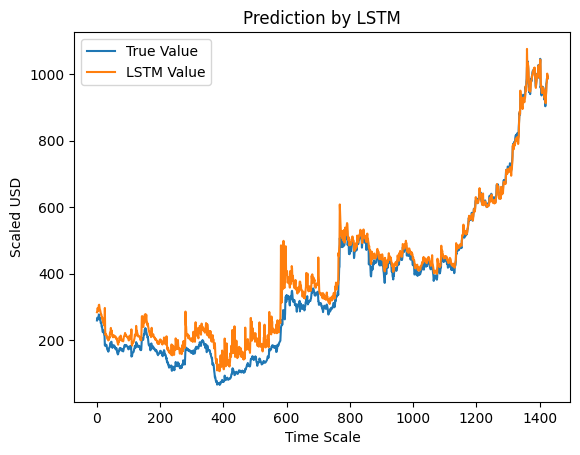

In [47]:
from matplotlib import pyplot as plt

#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and prepare the test data
df_test = pd.read_csv('DataSets/TATAMOTORS_18_JUN_2024_18_AUG_2024.csv')
df_test = df_test.dropna()
df_test = df_test[df_test['Volume'] != 0]

# Select the features and the target
X_test = df_test[['Open', 'Low', 'High', 'Volume']]
y_test = df_test['Close']

# Scale the test features using the same scaler as the training data
X_test_scaled = scaler.transform(X_test)

# Reshape the test data to match the input shape expected by the LSTM model
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Predict the close prices using the LSTM model
predictions = lstm.predict(X_test_scaled, verbose=0)

# Reshape predictions and true values to be 1D arrays
predictions = predictions.flatten()
y_test = y_test.values

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optional: Print out the first few predictions alongside the actual values
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Difference': y_test - predictions
})

print(df_results.head())


Mean Squared Error (MSE): 207.71273645687202
Mean Absolute Error (MAE): 10.62515989592634
       Actual   Predicted  Difference
0  985.900024  994.268005   -8.367981
1  977.349976  982.604004   -5.254028
2  978.250000  976.947205    1.302795
3  961.799988  973.190735  -11.390747
4  958.049988  951.588196    6.461792


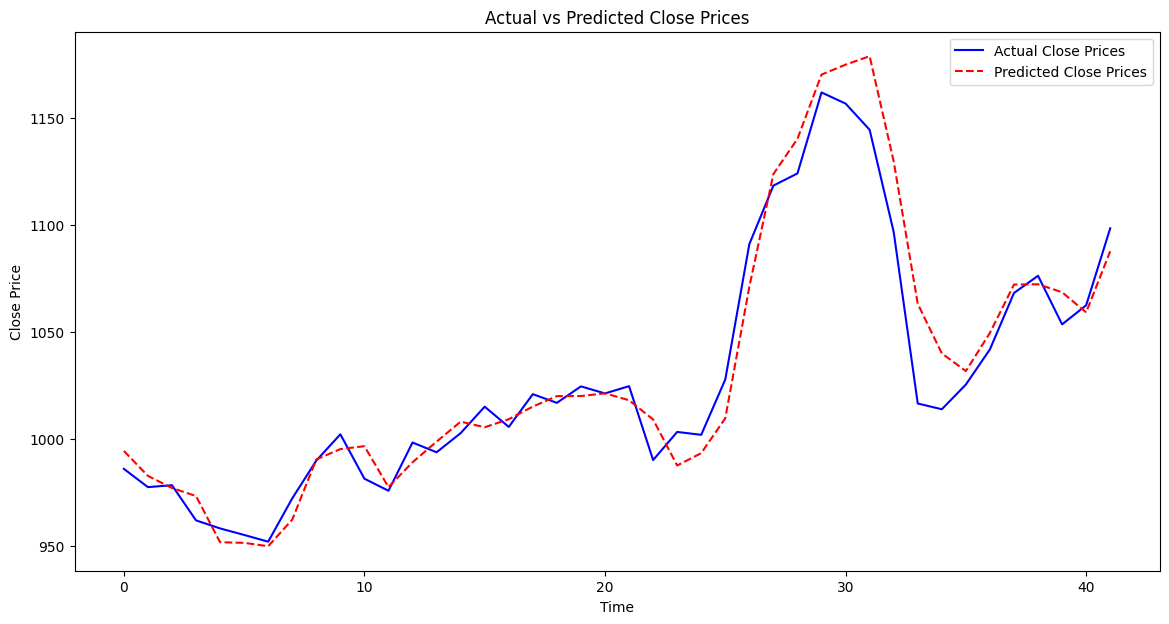

In [49]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted close prices
plt.figure(figsize=(14, 7))
plt.plot(df_test.index, y_test, color='blue', label='Actual Close Prices')
plt.plot(df_test.index, predictions, color='red', linestyle='--', label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
lstm.save('TataMotors_Stock_Price_Prediction_Model_LSTM_v1.h5')

In [16]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, 'scaler_v1.save')

['scaler.save']